# Project \#4: Find the “Largest” Digit

## Part 2 : Neural Network (feed-forward, adaptive-learning rate, momentum, regularization)

In [1]:
%matplotlib inline

In [2]:
import pandas, numpy as np
import matplotlib.pyplot as plt
import scipy.misc 

## Load the preprocessed data

In [5]:
data_x = np.loadtxt("../Datasets/processed_train_x.csv", delimiter=",") 
data_y = np.loadtxt("../Datasets/train_y.csv", delimiter=",") 

data_y = [preprocess_y(y) for y in data_y]
data_x = [x.reshape((625,1)) for x in data_x]
full_data = zip(data_x, data_y)
random.shuffle(full_data)

#do an 80/20 split for training/test: 
num_examples = np.shape(data_x)[0]
split = int(0.8 * num_examples)
train_data = full_data[:split]
test_data = full_data[split:]

## Load the Standard MNIST data

In [6]:
MNIST_test = np.loadtxt("../MNIST_Datasets/mnist_test.csv", delimiter=",") 
MNIST_train = data_x = np.loadtxt("../MNIST_Datasets/mnist_train.csv", delimiter=",") 

In [38]:
MNIST_test_y = [preprocess_y(y) for y in MNIST_test[:,0]]
MNIST_test_x = [x.reshape((784,1)) for x in MNIST_test[:,1:]]
MNIST_test_data = zip(MNIST_test_x, MNIST_test_y)

MNIST_train_y = [preprocess_y(y) for y in MNIST_train[:,0]]
MNIST_train_x = [x.reshape((784,1)) for x in MNIST_train[:,1:]]
MNIST_train_data = zip(MNIST_train_x, MNIST_train_y)

# Feed Forward Neural Network

In [41]:
import random

def preprocess_y(y):
    y = int(y)
    new_y = np.zeros(10)
    new_y[y] = 1.0
    return new_y.T.reshape((10,1))


def sigmoid(z, derivative):
    sig = 1.0 / (1.0 + np.exp(-z))
    if derivative == False:
        return sig
    else:
        return sig * (1 - sig)   

class Network(object):
    def __init__(self, sizes, norm, mom, lr):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.__init__weights()
        self.__init__biases()
        self.momentum_coef = mom
        self.norm = norm
        self.lr = lr
        
    def __init__weights(self):
        #weights are initialized using Glorot initialization
        self.weights = [np.random.uniform(-np.sqrt(6)/np.sqrt(x+y), np.sqrt(6)/np.sqrt(x+y),(y, x)) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def __init__biases(self):
        #Biases are initialized randomly
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
  
    #Feed Forward method computes the output vector of Neural Network assuming that the weights are trained
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = np.dot(w, a) + b
            a = sigmoid(a,derivative = False)
        return a
    
    def Stochasitc_Gradient_Descent(self, training_data, epochs, mini_batch_size, test_data = None):
        learning_rate = self.lr
        best_result = 0
        n = len(training_data)
        if test_data != None: 
            n_test = len(test_data)
        test_results = [0.0]    
        for j in xrange(epochs):
            random.shuffle(training_data)
            batches = [training_data[k : k + mini_batch_size] for k in xrange(0, n, mini_batch_size)]
            
            #Momentum Terms used to speed up crossing saddle points
            gradient_biases_old = [np.zeros(b.shape) for b in self.biases]
            gradient_weights_old = [np.zeros(w.shape) for w in self.weights]
            
            for batch in batches:
                gradient_biases = [np.zeros(b.shape) for b in self.biases]
                gradient_weights = [np.zeros(w.shape) for w in self.weights]
                
                #Momentum addition of previous gradient values
                momentum_biases = np.multiply(self.momentum_coef,gradient_biases_old)
                momentum_weights = np.multiply(self.momentum_coef,gradient_weights_old)
                
                #compute dC/dW for each example in batch and add them to gradent arrays
                for x, y in batch:
                    d_gradient_biases, d_gradient_weights = self.Compute_Gradient_Term(x, y)
                    gradent_biases = [gb + dgb for gb, dgb in zip(gradient_biases, d_gradient_biases)]
                    gradient_weights = [gw + dgw for gw, dgw in zip(gradient_weights, d_gradient_weights)]

                #Standard terms of the gradient update
                prefactor = float(-learning_rate / len(batch))
                gradient_biases  = np.multiply(prefactor, gradient_biases)
                gradient_weights  = np.multiply(prefactor, gradient_weights)
                
                #Update previous gradient updates to current gradients
                gradient_biases_old = gradient_biases
                gradient_weights_old = gradient_weights
                
                #Add update to weights and continue on next mini-batch
                self.weights = [(1-((self.norm*learning_rate)/len(batch)))*w + gw + mw  for w, gw, mw in zip(self.weights,gradient_weights, momentum_weights)]
                self.biases = [b + gb + mb for b, gb, mb in zip(self.biases,gradient_biases, momentum_biases)]

            
            if test_data:
                test = self.evaluate(test_data)
                print "Epoch %d: %f" %(j+1, test/float(n_test))
                test_results.append(test)
                #Adaptive Learning Rate:
                result_improvement = np.abs(test_results[-1] - test_results[-2])/ float(test_results[-2])
                #if there is little improvement from previous to current result then halve the learning rate
                if result_improvement < 0.001:
                    learning_rate = learning_rate / 2
                    #end the reduction of the learning rate
                    if learning_rate < 0.0005:
                        learning_rate = 0.0005
            else:
                print "Epoch %d complete" %j+1
        print "Training Completed!"
        return test_results

    def Compute_Gradient_Term(self, x, y):
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        #Feed Forward Step: pass the input into the neural network with the current version of the weights
        #and biases in order to obtain both the outputs at each layer and the activations at each layer
        activations = [x] 
        outputs = [] 
        for b, w in zip(self.biases, self.weights):
            x = np.dot(w, x)+b
            outputs.append(x)
            x = sigmoid(x, derivative = False)
            activations.append(x)
        #Backward Pass: back propogate the errors of the previous forward pass step in order to compute
        #the gradient updates for this specific image in the mini-batch
        #The gradients of biases and weights will be averaged across the mini-batch and the update will be applied.
        delta = (activations[-1] - y) * sigmoid(outputs[-1], derivative = True)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        for n in xrange(2, self.num_layers):
            delta = np.dot(self.weights[-n+1].T, delta) * sigmoid(outputs[-n], derivative = True)
            grad_b[-n] = delta
            grad_w[-n] = np.dot(delta, activations[-n-1].T)
        return (grad_b, grad_w)
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                        for (x, y) in test_data]
        results = sum(int(x == y) for (x, y) in test_results)
        return results
    
    def save_values(self):
        np.savetxt("../best_weights_0.txt",self.weights[0])
        np.savetxt("../best_weights_1.txt",self.weights[1])
        np.savetxt("../best_biases_0.txt",self.biases[0])
        np.savetxt("../best_biases_1.txt",self.biases[1])

## Baseline test: MNIST vs. Modified MNIST (same hyper-parameters)

In [46]:
print "Training Network 1 on ", len(train_data)," preprocessed training images" 
shape_1 = [625, 150, 10]
net_1 = Network(shape_1, 0.1, 0.1, 0.1)
ModMNIST_results = net_1.Stochasitc_Gradient_Descent(train_data, 30, 100, test_data = test_data) 
print 
print

print "Training Network 2 on ", len(MNIST_train_data)," MNIST training images" 
shape_2 = [784,150,10]
net_2 = Network(shape_2,0.1, 0.1, 0.1)
MNIST_results = net_2.Stochasitc_Gradient_Descent(MNIST_train_data, 30, 100, test_data = MNIST_test_data)   

Training Network 1 on  40000  preprocessed training images


/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in exp


Epoch 1: 0.625000


/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in double_scalars


Epoch 2: 0.684800
Epoch 3: 0.709800
Epoch 4: 0.721800
Epoch 5: 0.732400
Epoch 6: 0.737700
Epoch 7: 0.742900
Epoch 8: 0.751000
Epoch 9: 0.755600
Epoch 10: 0.765300
Epoch 11: 0.766300
Epoch 12: 0.769900
Epoch 13: 0.777600
Epoch 14: 0.771800
Epoch 15: 0.783500
Epoch 16: 0.781200
Epoch 17: 0.778800
Epoch 18: 0.784800
Epoch 19: 0.785800
Epoch 20: 0.792200
Epoch 21: 0.786900
Epoch 22: 0.792300
Epoch 23: 0.795600
Epoch 24: 0.797000
Epoch 25: 0.791400
Epoch 26: 0.792300
Epoch 27: 0.794300
Epoch 28: 0.796500
Epoch 29: 0.797100
Epoch 30: 0.807300
Training Completed!


Training Network 2 on  60000  MNIST training images
Epoch 1: 0.893400
Epoch 2: 0.914700
Epoch 3: 0.923800
Epoch 4: 0.929700
Epoch 5: 0.932700
Epoch 6: 0.935900
Epoch 7: 0.937800
Epoch 8: 0.940400
Epoch 9: 0.941700
Epoch 10: 0.939600
Epoch 11: 0.945500
Epoch 12: 0.946300
Epoch 13: 0.948500
Epoch 14: 0.950000
Epoch 15: 0.951100
Epoch 16: 0.951700
Epoch 17: 0.953500
Epoch 18: 0.954100
Epoch 19: 0.954400
Epoch 20: 0.954400
Epoch 21: 0.

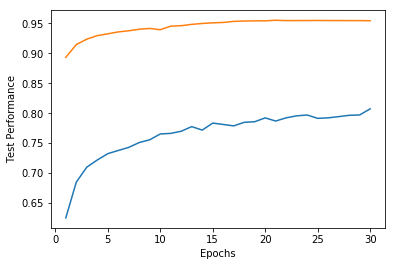

In [48]:
plt.plot(range(1,31), np.divide(ModMNIST_results[1:], 10000.0),label = 'Modified MNIST NN')
plt.plot(range(1,31), np.divide(MNIST_results[1:], 10000.0), label = 'Modified MNIST NN')
plt.xlabel("Epochs")
plt.ylabel("Test Performance")
plt.savefig("../MNIST_vs_mod.png",dpi = 700)
plt.show()


## Optimize the hyper-parameters using Grid-search

In [53]:
def Optimize():
    epochs = 30
    batch_size = 100
    learning_rates = [0.1, 0.2]   #initially had higher starting learning rates, but was clear they were slower to converge.
    hidden_sizes = [20, 50, 100, 200, 300, 400]
    #Grid_search for optimal parameters:
    print "Grid search of hyper-parameters: hidden-layer size, and learning_rate"
    Grid_data = []
    Grid_vals = []
    count  = 0
    for rate in learning_rates:
        for h_size in hidden_sizes:
            count += 1
            shape = [625, h_size, 10]
            net = Network(shape, 0.1, 0.1, 0.1)
            print "%d:            Learning Rate: %f       Hidden-Layer Size: %f" %(count, rate, h_size)
            data = net.Stochasitc_Gradient_Descent(train_data, epochs, batch_size, test_data = test_data)   
            Grid_data.append(data)
    return Grid_data

In [540]:
data_supreme = Optimize()
np.savetxt("../grid_data.txt",data_supreme)

Grid search of hyper-parameters: hidden-layer size, and learning_rate
1:            Learning Rate: 0.100000       Hidden-Layer Size: 20.000000


/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


Epoch 1: 3513 / 10000


/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: RuntimeWarning: divide by zero encountered in double_scalars


Epoch 2: 4557 / 10000
Epoch 3: 5095 / 10000
Epoch 4: 5206 / 10000
Epoch 5: 5634 / 10000
Epoch 6: 5761 / 10000
Epoch 7: 5846 / 10000
Epoch 8: 5981 / 10000
Epoch 9: 5857 / 10000
Epoch 10: 6136 / 10000
Epoch 11: 6171 / 10000
Epoch 12: 6208 / 10000
Epoch 13: 6247 / 10000
Epoch 14: 6348 / 10000
Epoch 15: 6495 / 10000
Epoch 16: 6332 / 10000
Epoch 17: 6443 / 10000
Epoch 18: 6561 / 10000
Epoch 19: 6417 / 10000
Epoch 20: 6308 / 10000
Epoch 21: 6427 / 10000
Epoch 22: 6530 / 10000
Epoch 23: 6561 / 10000
Epoch 24: 6352 / 10000
Epoch 25: 6518 / 10000
Epoch 26: 6419 / 10000
Epoch 27: 6543 / 10000
Epoch 28: 6574 / 10000
Epoch 29: 6664 / 10000
Epoch 30: 6580 / 10000
Training Completed!
2:            Learning Rate: 0.100000       Hidden-Layer Size: 50.000000
Epoch 1: 5237 / 10000
Epoch 2: 5978 / 10000
Epoch 3: 6233 / 10000
Epoch 4: 6479 / 10000
Epoch 5: 6489 / 10000
Epoch 6: 6654 / 10000
Epoch 7: 6804 / 10000
Epoch 8: 6868 / 10000
Epoch 9: 6823 / 10000
Epoch 10: 6975 / 10000
Epoch 11: 6935 / 10000
Epoc

KeyboardInterrupt: 

#### grid search shows that the larger hidden layers perform better, but have diminishing returns, so a hidden layer size of 150 was chosen to optimize performance as well as  minimize run time  [hidden layers of sizes 200,300,400 only did marginally better]

## Plot results from Optimization of hyper-parameters

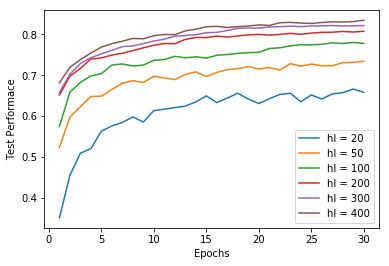

In [52]:
lr1hl20 = [0.3513, 0.4557, 0.5095, 0.5206, 0.5634, 0.5761, 0.5846, 0.5981, 0.5857, 0.6136, 0.6171, 0.6208, 0.6247, 0.6348, 0.6495, 0.6332, 0.6443, 0.6561, 0.6417, 0.6308, 0.6427, 0.6530, 0.6561, 0.6352, 0.6518, 0.6419, 0.6543, 0.6574, 0.6664, 0.6580]
lr1hl50 = [0.5237, 0.5978, 0.6233, 0.6479, 0.6489, 0.6654, 0.6804, 0.6868, 0.6823, 0.6975, 0.6935, 0.6893, 0.7020, 0.7083, 0.6967, 0.7070, 0.7135, 0.7159, 0.7212, 0.7152, 0.7190, 0.7125, 0.7284, 0.7221, 0.7273, 0.7230, 0.7233, 0.7305, 0.7316, 0.7340]
lr1hl100 = [0.5747, 0.6586, 0.6827, 0.6983, 0.7039, 0.7249, 0.7276, 0.7226, 0.7248, 0.7365, 0.7385, 0.7462, 0.7426, 0.7451, 0.7419, 0.7489, 0.7507, 0.7534, 0.7552, 0.7559, 0.7652, 0.7671, 0.7717, 0.7748, 0.7741, 0.7757, 0.7792, 0.7776, 0.7802, 0.7777]
lr1hl200 = [0.6516, 0.6978, 0.7166, 0.7397, 0.7423, 0.7493, 0.7538, 0.7602, 0.7669, 0.7733, 0.7774, 0.7772, 0.7876, 0.7923, 0.7920, 0.7957, 0.7932, 0.7960, 0.7985, 0.8000, 0.7978, 0.8000, 0.8022, 0.8001, 0.8030, 0.8048, 0.8051, 0.8070, 0.8056, 0.8075]
lr1hl300 = [0.6581, 0.7025, 0.7286, 0.7430, 0.7523, 0.7608, 0.7700, 0.7716, 0.7774, 0.7836, 0.7882, 0.7954, 0.7970, 0.7991, 0.8040, 0.8048, 0.8093, 0.8147, 0.8153, 0.8152, 0.8179, 0.8187, 0.8199, 0.8188, 0.8205, 0.8206, 0.8215, 0.8205, 0.8208, 0.8214]
lr1hl400 = [0.6812, 0.7193, 0.7383, 0.7542, 0.7688, 0.7772, 0.7832, 0.7900, 0.7891, 0.7966, 0.7997, 0.7992, 0.8084, 0.8125, 0.8185, 0.8195, 0.8167, 0.8189, 0.8202, 0.8230, 0.8216, 0.8283, 0.8292, 0.8274, 0.8265, 0.8289, 0.8304, 0.8301, 0.8312, 0.8344]
lr2hl20 = [0.3262, 0.4291, 0.4672, 0.4705, 0.4969, 0.4970, 0.5270, 0.5383, 0.5433, 0.5583, 0.5552, 0.5811, 0.5615, 0.5630, 0.5700, 0.5710, 0.5951, 0.5652, 0.6000, 0.5937, 0.5939, 0.5888, 0.5976, 0.6139, 0.5947, 0.6123, 0.6010, 0.6171, 0.6157, 0.6131]
lr2hl50 = [0.5372, 0.5958, 0.6364, 0.6575, 0.6495, 0.6579, 0.6563, 0.6611, 0.6719, 0.6843, 0.6762, 0.6765, 0.6907, 0.6999, 0.7067, 0.7005, 0.7096, 0.7135, 0.7111, 0.7193, 0.7114, 0.7172, 0.7183, 0.7205, 0.7182, 0.7154, 0.7193, 0.7246, 0.7296, 0.7225]
lr2hl100 = [0.6140, 0.6505, 0.6762, 0.6767, 0.7156, 0.7162, 0.7266, 0.7263, 0.7361, 0.7379, 0.7391, 0.7393, 0.7430, 0.7407, 0.7466, 0.7457, 0.7463, 0.7484, 0.7463, 0.7488, 0.7481, 0.7485, 0.7478, 0.7481, 0.7481, 0.7483, 0.7483, 0.7481, 0.7475, 0.7478]
lr2hl200 = [0.6666, 0.6905, 0.7157, 0.7282, 0.7316, 0.7382, 0.7464, 0.7478, 0.7534, 0.7584, 0.7572, 0.7538, 0.7630, 0.7632, 0.7738, 0.7745, 0.7821, 0.7899, 0.7867, 0.7908, 0.7897, 0.7933, 0.7943, 0.7946, 0.7947, 0.7958, 0.7983, 0.7997, 0.7993, 0.7987]
lr2hl300 = [0.6690, 0.7114, 0.7289, 0.7419, 0.7515, 0.7511, 0.7672, 0.7769, 0.7780, 0.7830, 0.7832, 0.7920, 0.7951, 0.7983, 0.8013, 0.7989, 0.8048, 0.8045, 0.8063, 0.8076, 0.8092, 0.8092, 0.8106, 0.8096, 0.8099, 0.8104, 0.8122, 0.8114, 0.8116, 0.8122]
lr2hl400 = [0.6927, 0.7227, 0.7375, 0.7535, 0.7677, 0.7629, 0.7754, 0.7769, 0.7860, 0.7857, 0.7947, 0.7988, 0.8014, 0.8038, 0.8083, 0.8102, 0.8109, 0.8155, 0.8176, 0.8183, 0.8205, 0.8218, 0.8240, 0.8198, 0.8240, 0.8223, 0.8235, 0.8234, 0.8223, 0.8249]
combinations = [lr1hl20, lr1hl50, lr1hl100, lr1hl200, lr1hl300, lr1hl400, lr2hl20, lr2hl50, lr2hl100, lr2hl200, lr2hl300, lr2hl400]
labels = ['hl = 20', 'hl = 50', 'hl = 100', 'hl = 200', 'hl = 300', 'hl = 400']
domain = range(1,31)
for i in range(0,6):
    #plotting only the configurations with learning rate  = 0.1, since 0.2 overall performed worse (slower convergence)
    plt.plot(domain,combinations[i], label = labels[i])
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Test Performace")
plt.savefig("../new_fig.png", dpi = 800)
plt.show()

## Configuration of NN with parameters that optimize performance/minimize runtime

/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: overflow encountered in exp


Epoch 1: 0.615000


/Users/jacksklar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:93: RuntimeWarning: divide by zero encountered in double_scalars


Epoch 2: 0.682100
Epoch 3: 0.706600
Epoch 4: 0.714700
Epoch 5: 0.727600
Epoch 6: 0.733000
Epoch 7: 0.742000
Epoch 8: 0.755300
Epoch 9: 0.749400
Epoch 10: 0.765000
Epoch 11: 0.759800
Epoch 12: 0.766000
Epoch 13: 0.770700
Epoch 14: 0.775800
Epoch 15: 0.779800
Epoch 16: 0.780500
Epoch 17: 0.784200
Epoch 18: 0.787200
Epoch 19: 0.792900
Epoch 20: 0.795700
Epoch 21: 0.799700
Epoch 22: 0.798600
Epoch 23: 0.797400
Epoch 24: 0.797000
Epoch 25: 0.805300
Epoch 26: 0.803200
Epoch 27: 0.807200
Epoch 28: 0.803300
Epoch 29: 0.805600
Epoch 30: 0.807300
Training Completed!


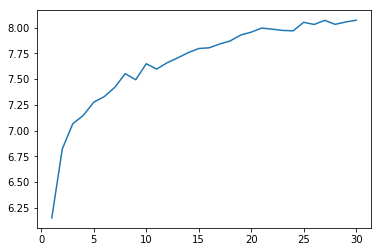

In [60]:
shape = [625, 150, 10]
net = Network(shape, 0.1, 0.1, 0.1)
opt_150 = net.Stochasitc_Gradient_Descent(train_data, 30, 100, test_data = test_data) 
plt.plot(range(1,31),np.divide(opt_150[1:],10000.0))
plt.savefig("../opt_150.png", dpi = 700)

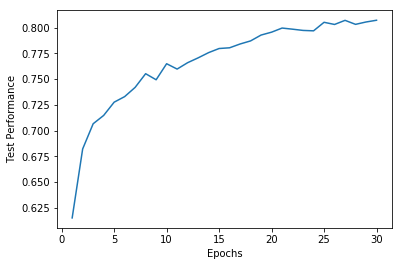

In [62]:
plt.plot(range(1,31),np.divide(opt_150[1:],10000.0))
plt.xlabel("Epochs")
plt.ylabel("Test Performance")
plt.savefig("../opt_150.png", dpi = 700)